# Iris dataset species classification

In [1]:
import numpy as np
import pandas as pd

In [2]:
iris = pd.read_csv('../DATA/iris.csv')

In [3]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
iris['species'].unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [5]:
# iris['target'] = iris['species'].map({'setosa': 1, 'versicolor': 2, 'virginica': 3 })

iris = pd.get_dummies(data=iris, columns=['species'], dtype=int)


In [6]:
iris

,sepal_length,sepal_width,petal_length,petal_width,species_setosa,species_versicolor,species_virginica
0,5.1,3.5,1.4,0.2,1,0,0
1,4.9,3.0,1.4,0.2,1,0,0
2,4.7,3.2,1.3,0.2,1,0,0
3,4.6,3.1,1.5,0.2,1,0,0
4,5.0,3.6,1.4,0.2,1,0,0
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,0,0,1
146,6.3,2.5,5.0,1.9,0,0,1
147,6.5,3.0,5.2,2.0,0,0,1
148,6.2,3.4,5.4,2.3,0,0,1


# NN Model using Tensorflow Keras

In [7]:
from sklearn.model_selection import train_test_split

X = iris.drop(['species_setosa', 'species_versicolor', 'species_virginica'], axis=1)
y = iris[['species_setosa', 'species_versicolor', 'species_virginica']]



In [8]:
y = np.array(y)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
X_train.shape

# 120 rows, 4 columns/features

(120, 4)

In [12]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(4, activation='relu', input_shape=[4, ])) # 4 features, and not feeding in batches
model.add(Dense(3, activation='softmax')) # softmax for multi-class classification

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 20        
                                                                 
 dense_1 (Dense)             (None, 3)                 15        
                                                                 
Total params: 35 (140.00 Byte)
Trainable params: 35 (140.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(patience=20)

model.fit(X_train, y_train, epochs=360, validation_data=(X_test, y_test), callbacks=[earlystop], verbose=False)

<Axes: >

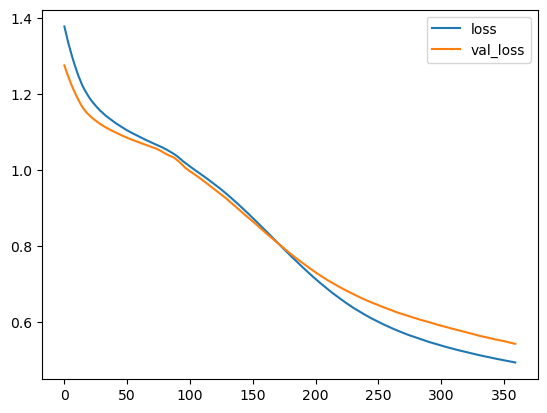

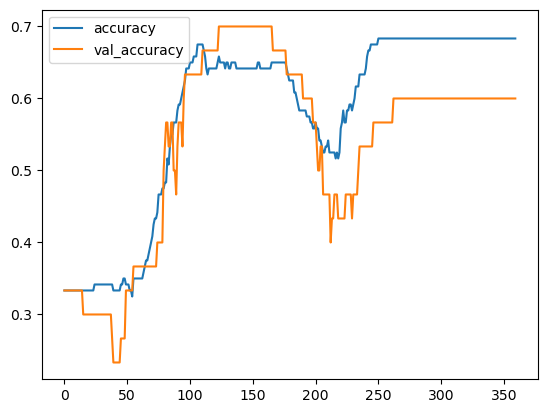

In [14]:
loss_df = pd.DataFrame(model.history.history)

loss_df[['loss', 'val_loss']].plot()

loss_df[['accuracy', 'val_accuracy']].plot()

In [15]:
model.evaluate(X_test, y_test)

# loss, accuracy

1/1 [==============================] - 0s 11ms/step - loss: 0.5423 - accuracy: 0.6000


[0.5422801971435547, 0.6000000238418579]

# Fit final model on all data 

In [16]:
all_X = scaler.fit_transform(X)
all_X = np.array(all_X)

In [17]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(4, activation='relu', input_shape=[4, ])) # 4 features, and not feeding in batches
model.add(Dense(3, activation='softmax')) # softmax for multi-class classification

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [18]:
model.fit(all_X, y, epochs=360, verbose=False)

# Save model and scaler for deployment

In [19]:
model.save("final_iris_model.h5")

/Users/soohian/opt/anaconda3/envs/deployment/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
import joblib

joblib.dump(scaler, 'iris_scaler.pkl') # save the scaler too

['iris_scaler.pkl']

In [21]:
from tensorflow.keras.models import load_model

flower_model = load_model('final_iris_model.h5')
flower_scaler = joblib.load('iris_scaler.pkl')

# Prediction function for deployment

In [22]:
iris.head(1)

,sepal_length,sepal_width,petal_length,petal_width,species_setosa,species_versicolor,species_virginica
0,5.1,3.5,1.4,0.2,1,0,0


In [23]:
flower_example = {
    'sepal_length': 5.1,
    'sepal_width':3.5,
    'petal_length': 1.4,
    'petal_width': 0.2
}

In [24]:
def return_prediction(model, scaler, sample_json):
    s_len = sample_json['sepal_length']
    s_wid = sample_json['sepal_width']
    p_len = sample_json['petal_length']
    p_wid = sample_json['petal_width']

    flower = [[s_len, s_wid, p_len, p_wid]]
    flower = scaler.transform(flower)
    
    classes = np.array(['setosa', 'versicolor', 'virginica'])

    class_probs = model.predict(flower)
    
    class_ind = np.argmax(class_probs)
    
    return classes[class_ind]
    

In [25]:
return_prediction(flower_model, flower_scaler, flower_example)

1/1 [==============================] - 0s 29ms/step


/Users/soohian/opt/anaconda3/envs/deployment/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


'setosa'

# Code for deployment

In [26]:
from tensorflow.keras.models import load_model
import numpy as np
import joblib

flower_model = load_model('final_iris_model.h5')
flower_scaler = joblib.load('iris_scaler.pkl')

def return_prediction(model, scaler, sample_json):
    s_len = sample_json['sepal_length']
    s_wid = sample_json['sepal_width']
    p_len = sample_json['petal_length']
    p_wid = sample_json['petal_width']

    flower = [[s_len, s_wid, p_len, p_wid]]
    flower = scaler.transform(flower)
    
    classes = np.array(['setosa', 'versicolor', 'virginica'])
    class_probs = model.predict(flower)
    class_ind = np.argmax(class_probs)
    
    return classes[class_ind]